https://zhuanlan.zhihu.com/p/31170525

把各国各语言人名都转化成用26个英文字母来表示

In [3]:
import glob
import unicodedata
import string

In [4]:
# 支持打印的字符+标点字符
all_letters = string.ascii_letters + " .,;'-"
# Plus EOS marker
n_letters = len(all_letters) + 1
EOS = n_letters - 1
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in all_letters)
print(unicode_to_ascii("O'Néàl"))

O'Neal


In [5]:
print('all_letters:',all_letters)
print('n_letters:',n_letters)
print('EOS:',EOS)

all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-
n_letters: 59
EOS: 58


读取数据

In [6]:
# 按行取出文件中的名字，并返回包含所有名字的列表
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]
# category_lines是一个字典，其中索引是国家名字，内容是从文件读出的这个国家的所有名字
category_lines = {}
# all_categories是一个列表，包含了所有的国家名字
all_categories = []
for filename in glob.glob('names/*.txt'):
    # 从文件名中切割出国家名字
#     print(filename)
    category = filename.split('\\')[-1].split('.')[0]
#     print(category)
    # 将国家名字添加到列表中
    all_categories.append(category)
    # 读取对应国家文件中所有的名字
    lines = read_lines(filename)
#     print(lines)
    category_lines[category] = lines
# 共有的国别数
n_categories = len(all_categories)
print('# categories: ', n_categories, all_categories)
print()
print('# names: ', category_lines['Russian'][:10])

# categories:  18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']

# names:  ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin']


搭建神经网络

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

准备训练

In [8]:
# 随机选择数据对(category,line)
import random
def random_training_pair():
    # 随机选择一个国家名
    category = random.choice(all_categories)
    # 读取这个国名下的所有人名
    line = random.choice(category_lines[category])
    return category,line

# 将名字所属的国家转化为独热向量
def make_category_input(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return Variable(tensor)
# 将一个名字转化成矩阵Tensor
# 矩阵的每行为名字中每个字符的独热编码向量
def make_chars_input(chars):
    tensor = torch.zeros(len(chars), n_letters)
    # 遍历每个名字中的每个字符
    for ci in range(len(chars)):
        char = chars[ci]
        # 独热编码
        tensor[ci][all_letters.find(char)] = 1
    # 增加一个维度
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor)

# 将“目标”，也就是“下一个字符”转化为Tensor
# 注意这里最后以 EOS 作为结束标志
def make_target(line):
    # 从第2个字符开始，取出每个字符的索引
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    # 在最后加上 EOS 的索引
    letter_indexes.append(n_letters - 1) # EOS
    # 转化成 LongTensor
    tensor = torch.LongTensor(letter_indexes)
    return Variable(tensor)

同样为了训练时方便使用，我们建立一个 random_training_set 函数，以随机选择出数据集 (category, line) 并转化成训练需要的 Tensor： (category, input, target)

In [9]:
def random_training_set():
    # 随机选择数据集
    category, line = random_training_pair()
    # 转化成对应 Tensor
    category_input = make_category_input(category)
    line_input = make_chars_input(line)
    line_target = make_target(line)
#     print(type(category_input),type(line_input),type(line_target))
    return category_input, line_input, line_target

开始训练

与之前处理得分类问题不同，在分类问题中只有最后的输出被使用。而在当前的 生成 名字的任务中，神经网络在每一步都会做预测，所以我们需要在每一步计算损失值。

In [10]:
def train(category_tensor, input_line_tensor, target_line_tensor):
#     print(type(category_tensor),type(input_line_tensor),type(target_line_tensor))
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i].unsqueeze(0))

    loss.backward()
    optimizer.step()
    
#     return output, loss.data[0] / input_line_tensor.size()[0]
    return output,loss.data.item() / input_line_tensor.size()[0]

定义 time_since 函数，它可以打印出训练持续的时间

In [11]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0.0005

0m 18s (5000 5%) 1.8631
0m 36s (10000 10%) 2.7527
0m 53s (15000 15%) 1.8259
1m 12s (20000 20%) 2.4873
1m 30s (25000 25%) 2.2942
1m 47s (30000 30%) 1.7694
2m 5s (35000 35%) 1.4632
2m 23s (40000 40%) 1.8028
2m 41s (45000 45%) 1.6641
2m 59s (50000 50%) 2.0882
3m 17s (55000 55%) 2.5928
3m 35s (60000 60%) 1.4729
3m 53s (65000 65%) 2.7800
4m 13s (70000 70%) 3.2103
4m 32s (75000 75%) 2.8172
4m 51s (80000 80%) 2.1803
5m 9s (85000 85%) 1.7438
5m 27s (90000 90%) 1.4743
5m 45s (95000 95%) 1.3808
6m 3s (100000 100%) 1.8329


损失曲线

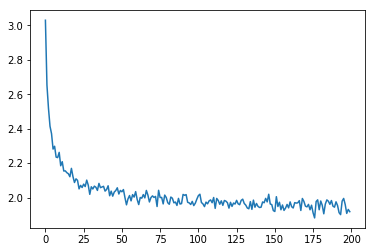

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)


测试使用神经网络

In [14]:
max_length = 20
# 通过指定国别名 category
# 以及开始字符 start_char
# 还有混乱度 temperature 来生成一个名字


def generate_one(category, start_char='A', temperature=0.5):
    category_input = make_category_input(category)
    chars_input = make_chars_input(start_char)
    hidden = rnn.init_hidden()

    output_str = start_char

    for i in range(max_length):
        output, hidden = rnn(category_input, chars_input[0], hidden)

        # 这里是将输出转化为一个多项式分布
        output_dist = output.data.view(-1).div(temperature).exp()
        # 从而可以根据混乱度 temperature 来选择下一个字符
        # 混乱度低，则趋向于选择网络预测最大概率的那个字符
        # 混乱度高，则趋向于随机选择字符
        top_i = torch.multinomial(output_dist, 1)[0]

        # 生成字符是 EOS，则生成结束
        if top_i == EOS:
            break
        else:
            char = all_letters[top_i]
            output_str += char
            chars_input = make_chars_input(char)

    return output_str

# 再定义一个函数，方便每次生成多个名字


def generate(category, start_chars='ABC'):
    for start_char in start_chars:
        print(generate_one(category, start_char))

In [31]:
generate('Chinese', 'Jiang')

Jen
ino
ano
nin
gun
